# Tutorial analysis

In this tutorial, you'll install lacuna and run your first analysis.

**What you'll learn**:

- Install lacuna and its dependencies
- Verify your installation is working correctly
- Load the tutorial lesion dataset
- Fetch connectomes
- Run an exemplary analysis with the command line interface (CLI)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m-petersen/lacuna/blob/main/docs/tutorials/getting-started.ipynb)


In [7]:
# --- Conda Setup For Colab ---
# Ignore this cell if you run the notebook locally
import os

try:
    import google.colab  # present only in Colab
except Exception:
    print("Not running in Colab — skipping Conda setup")
else:
    if not os.path.exists("/usr/local/conda"):
        !pip install -q condacolab
        import condacolab
        condacolab.install()

Not running in Colab — skipping Conda setup


## Prerequisites

- conda or mamba environment with Python 3.10 or higher
- A terminal

## Install lacuna and its dependencies

In [ ]:
# Install Lacuna from GitHub
#Note: ! enables shell commands in Jupyter
!pip install git+https://github.com/m-petersen/lacuna

# Install MRtrix3
!conda install -c conda-forge -c MRtrix3 mrtrix3 libstdcxx-ng


  Cloning https://github.com/m-petersen/lacuna to /tmp/pip-req-build-411rabj6
  Running command git clone --filter=blob:none --quiet https://github.com/m-petersen/lacuna /tmp/pip-req-build-411rabj6
  Resolved https://github.com/m-petersen/lacuna to commit 2d9da35692d9d13bcdae0fe1548836cbb9594011
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lacuna: filename=lacuna-0.0.1.dev324-py3-none-any.whl size=4657519 sha256=db3677890f076b5ebd5ed87daa63ad0a8a6bfecaf281f1dc236980017e1fdf90
  Stored in directory: /tmp/pip-ephem-wheel-cache-ptyffxk6/wheels/f2/47/73/b700514669e601f0dde178de2d7016138fa840bd514ac68002
Successfully built lacuna
  Attempting uninstall: lacuna
    Found existing installation: lacuna 0.0.1.dev322
    Uninstalling lacuna-0.0.1.dev322:
      Successfully uninstalled lacuna-0.0.1.dev322


In [6]:
# Verify installation
!lacuna --version

lacuna 0.0.1.dev322


## The Lacuna CLI

Lacuna offers the user two ways of using it via (1) the CLI and (2) via the Python API. While the Python API offers more flexibility, we will cover it in later tutorials and focus here on the CLI as it offers the most straight-forward user experience.

The CLI is hierarchically structured in subcommands following a typical lesion analysis workflow.

```
lacuna
└─bidsify   # Transform your directory of masks in a BIDS-compliant dataset Lacuna can work with
└─run       # Run analyses
  └─rd      # Run regional damage analysis
  └─fnm     # Run functional network mapping
  └─snm     # Run structural network mapping
  └─...   
└─collect   # Collect data from individual-level output files to analysis-ready group-level tables 
└─tutorial  # Get the tutorial data
└─info      # Get info on available resources (e.g., available parcellation atlases)
```

You can further explore the functionality via the help pages

In [3]:
!lacuna --help

usage: lacuna [-h] [--version] <command> ...

Lacuna v0.0.1.dev314

options:
  -h, --help  show this help message and exit
  --version   show program's version number and exit

commands:
  Use 'lacuna <command> --help' for more information.

  <command>
    fetch     Download and setup connectomes
    run       Run lesion network mapping analyses
    collect   Aggregate parcelstats across subjects
    info      Display available resources (atlases, connectomes)
    bidsify   Convert NIfTI files to BIDS format
    tutorial  Setup tutorial data for learning Lacuna

Commands:
  bidsify   Convert NIfTI files to BIDS format
  fetch     Download and setup connectomes for analysis
  run       Run lesion analyses
  collect   Aggregate results across subjects
  info      Display available resources (atlases, connectomes)
  tutorial  Setup tutorial data for learning Lacuna

Examples:
  lacuna tutorial ./my_tutorial
  lacuna fetch gsp1000 --api-key \$DATAVERSE_API_KEY
  lacuna run rd /bids /outpu

## Get the tutorial data
Let's begin by loading the synthetic BIDS dataset included in Lacuna. This dataset is structured specifically for this demonstration and contains lesion masks in the required MNI space.

Lacuna simplifies analysis by managing coordinate spaces for you. It supports both MNI152NLin6Asym and MNI152NLin2009cAsym. Instead of requiring you to manually register your lesions, atlases, and connectomes to a single space, Lacuna uses [TemplateFlow](https://www.templateflow.org/) to handle these transformations internally. You only need to define the input space of your lesion masks; the toolbox ensures all other data is brought into alignment automatically.

Let's copy the data to a temporary directory.

In [ ]:
!lacuna tutorial /tmp/tutorial_data


Setting up tutorial data at: /tmp/tutorial_data
✓ Tutorial data copied to: /tmp/tutorial_data

The tutorial dataset includes:
  - 3 synthetic subjects (sub-01, sub-02, sub-03)
  - Binary lesion masks in MNI152NLin6Asym space
  - BIDS-compliant structure


In [31]:
!ls /tmp/tutorial_data

dataset_description.json  participants.tsv  sub-01  sub-03
__init__.py		  __pycache__	    sub-02


For illustration purposes we load one lesion mask and visualize it with nilearn

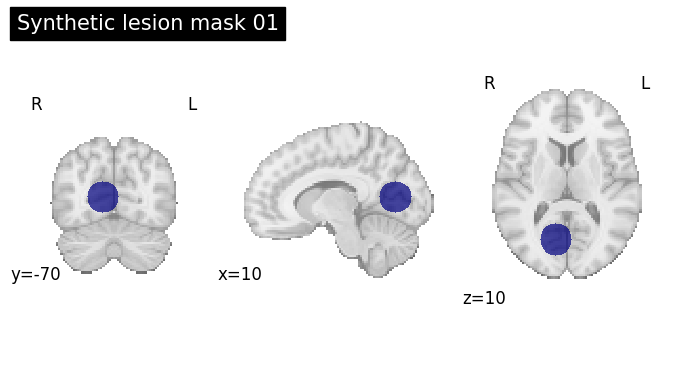

In [64]:
import nibabel as nib
from nilearn import plotting

lesion_path = '/tmp/tutorial_data/sub-01/ses-01/anat/sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_mask.nii.gz'
lesion_img = nib.load(lesion_path)

plotting.plot_roi(lesion_img, 
                       radiological=True, 
                       title="Synthetic lesion mask 01", 
                       draw_cross=False, 
                       colorbar=False) 

# Regional damage analysis

The first analysis we will run quantifies the overlap of the lesion mask with a parcellation atlas. Lacuna provides direct access to the Schaefer cortical and Tian (Melbourne) subcortical atlas in different resolutions. Moreover, the HCP1065 white matter tract atlas is included. Beyond that lacuna provides functionality to load your own atlases which will be covered in a separate how-to.

You can check the available atlases via the CLI

In [36]:
!lacuna info atlases


Available Brain Parcellations (Atlases)

Schaefer Cortical Parcellations:
  Schaefer2018TianS1_400Parcels17Networks       (MNI152NLin6Asym, 1mm)
  Schaefer2018TianS2_400Parcels17Networks       (MNI152NLin6Asym, 1mm)
  Schaefer2018TianS3_400Parcels17Networks       (MNI152NLin6Asym, 1mm)
  Schaefer2018_1000Parcels17Networks            (MNI152NLin6Asym, 1mm)
  Schaefer2018_1000Parcels7Networks             (MNI152NLin6Asym, 1mm)
  Schaefer2018_100Parcels17Networks             (MNI152NLin6Asym, 1mm)
  Schaefer2018_100Parcels7Networks              (MNI152NLin6Asym, 1mm)
  Schaefer2018_200Parcels17Networks             (MNI152NLin6Asym, 1mm)
  Schaefer2018_200Parcels7Networks              (MNI152NLin6Asym, 1mm)
  Schaefer2018_400Parcels17Networks             (MNI152NLin6Asym, 1mm)
  Schaefer2018_400Parcels7Networks              (MNI152NLin6Asym, 1mm)

Tian Subcortical Parcellations:
  TianSubcortex_3TS1                            (MNI152NLin6Asym, 1mm)
  TianSubcortex_3TS2                    

As you can see you are provided with some choices. Here, we will use Schaefer2018_100Parcels7Networks. If you use one of the atlases don't forget to cite the corresponding papers. 

We will run the command on the whole dataset. Specification of, e.g., `sub-01` is possible by adding `--participant-label 01`.

In [75]:
!lacuna run rd \
    /tmp/tutorial_data/ \
    /tmp/outputs/ \
    --parcel-atlases Schaefer2018_100Parcels7Networks \
    --mask-space MNI152NLin6Asym \
    --verbose

2026-01-20 14:31:53 - lacuna.cli.main - INFO - Lacuna CLI starting
2026-01-20 14:31:53 - lacuna.cli.main - INFO - Input: /tmp/tutorial_data
2026-01-20 14:31:53 - lacuna.cli.main - INFO - Output directory: /tmp/outputs
2026-01-20 14:31:53 - lacuna.cli.main - INFO - Analysis: rd
2026-01-20 14:31:53 - lacuna.cli.main - INFO - Running analysis: RegionalDamage
2026-01-20 14:31:54 - lacuna.cli.main - INFO - 
2026-01-20 14:31:54 - lacuna.cli.main - INFO - ============================================================
2026-01-20 14:31:54 - lacuna.cli.main - INFO - DISCOVERY SUMMARY
2026-01-20 14:31:54 - lacuna.cli.main - INFO - ============================================================
2026-01-20 14:31:54 - lacuna.cli.main - INFO -   Total mask images: 3
2026-01-20 14:31:54 - lacuna.cli.main - INFO -   Unique subjects:   3
2026-01-20 14:31:54 - lacuna.cli.main - INFO -   Unique sessions:   1
2026-01-20 14:31:54 - lacuna.cli.main - INFO -   Labels:            acuteinfarct
2026-01-20 14:31:54 - 

Let's take a look at the outputs

In [76]:
!ls /tmp/outputs/

dataset_description.json  sub-01  sub-02  sub-03


In [77]:
!ls /tmp/outputs/sub-01/ses-01/anat

sub-01_ses-01_desc-provenance.json
sub-01_ses-01_label-acuteinfarct_atlas-schaefer2018_desc-100parcels7networks_source-inputmask_parcelstats.json
sub-01_ses-01_label-acuteinfarct_atlas-schaefer2018_desc-100parcels7networks_source-inputmask_parcelstats.tsv
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_mask.nii.gz


We load and visualize the output file with pandas

In [79]:
import pandas as pd

output_tsv = "/tmp/outputs/sub-01/ses-01/anat/sub-01_ses-01_label-acuteinfarct_atlas-schaefer2018_desc-100parcels7networks_source-inputmask_parcelstats.tsv"
df = pd.read_csv(output_tsv, sep="\t")
df.sort_values(by="value", ascending=False).head(10)


,region,value
54,7Networks_RH_Vis_5,63.361935
55,7Networks_RH_Vis_6,28.837823
98,7Networks_RH_Default_pCunPCC_1,15.208071
5,7Networks_LH_Vis_6,11.231361
57,7Networks_RH_Vis_8,4.003756
8,7Networks_LH_Vis_9,1.594878
99,7Networks_RH_Default_pCunPCC_2,0.892061
48,7Networks_LH_Default_pCunPCC_1,0.739910
88,7Networks_RH_Cont_pCun_1,0.652838
2,7Networks_LH_Vis_3,0.577883


Schaefer area RH Vis 5 has an overlap of 63% with the lesion. Let's check that visually by plotting the atlas parcel.  

[fetch_atlas_schaefer_2018] Dataset found in /home/marvin/nilearn_data/schaefer_2018


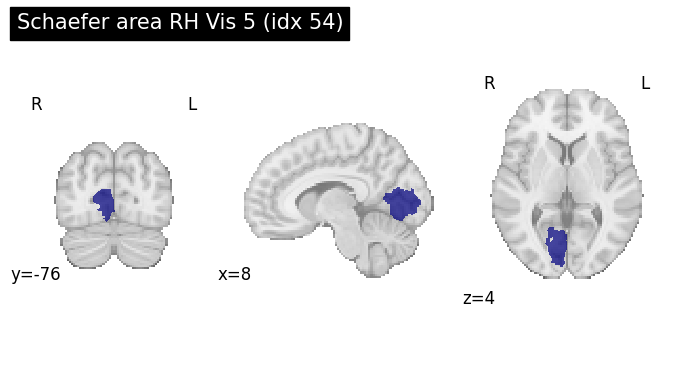

In [80]:
from nilearn import datasets
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
schaefer_img = nib.load(schaefer['maps'])
schaefer_data = schaefer_img.get_fdata()

# only 7Networks_RH_Vis_5 (idx 54)
schaefer_roi_54 = (schaefer_data == 55)
roi_img = nib.Nifti1Image(schaefer_roi_54, affine=schaefer_img.affine, header=schaefer_img.header)


plotting.plot_roi(roi_img, 
                       radiological=True, 
                       title="Schaefer area RH Vis 5 (idx 54)", 
                       draw_cross=False, 
                       colorbar=False)

Looks good.

## Collect tabular data in an analysis-ready file

Next, we will use `lacuna collect` to merge the individual-level tsv-files to one so that we can use it for downstream analyses

In [88]:
!lacuna collect \
    /tmp/tutorial_data/ \
    /tmp/outputs \
    --pattern "*schaefer2018*" # Pattern matching allows for selective collection

/home/marvin/mount/hdd8tb/CSI_MVCI/lacuna/src/lacuna/cli/main.py:278: UserWarning: No valid data for 'group_atlas-schaefer2018_desc-100parcels7networks_source-inputmask_parcelstats': 1 file(s) skipped due to incompatible format. Files need 'region' and 'value' columns.
  created_files = aggregate_parcelstats(


In [89]:
pd.read_csv('/tmp/outputs/group_atlas-schaefer2018_desc-100parcels7networks_source-inputmask_parcelstats.tsv',\
             sep="\t", index_col=0).head(10)

,session_id,label,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,...,7Networks_RH_Default_Temp_1,7Networks_RH_Default_Temp_2,7Networks_RH_Default_Temp_3,7Networks_RH_Default_PFCv_1,7Networks_RH_Default_PFCv_2,7Networks_RH_Default_PFCdPFCm_1,7Networks_RH_Default_PFCdPFCm_2,7Networks_RH_Default_PFCdPFCm_3,7Networks_RH_Default_pCunPCC_1,7Networks_RH_Default_pCunPCC_2
participant_id,,,,,,,,,,,,,,,,,,,,,
1,1,acuteinfarct,0.0,0.0,0.577883,0.0,0.118796,11.231361,0.0,0.0,...,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,15.208071,0.892061
2,1,acuteinfarct,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1,acuteinfarct,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,13.600105,5.60675,29.534862,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


# Structural Lesion Network Mapping

Structural lesion network mapping aims to identify the white matter fiber bundles connected to a specific lesion. By analyzing the lesion's location, we can infer which neural pathways have been disconnected or disrupted.

To perform this analysis, the lacuna requires a structural connectome, specifically a normative tractogram that represents a reconstruction of healthy white matter fiber bundles. Lacuna facilitates the download of the dTOR985 connectome via lacuna.fetch. This dataset is openly available on [figshare](https://springernature.figshare.com/articles/dataset/dTOR-985_structural_connectome_full_tractogram_trk_file/25209947).

To download this dataset programmatically, you must provide a Figshare personal token. You can obtain this token by logging into figshare.com, navigating to Account, then Integrations, and finally selecting Personal Tokens.

In [ ]:
YOUR_API_KEY="6c0aa307c3f59f7fca89e3ed75ec598812df83e073c57ebc8e339962ed54f8303941c0c213fea609369c36bfafff5a9a73b40c47ce6da4a75caaaca358360bda"
!lacuna fetch dtor985 \
    --api-key {YOUR_API_KEY} \
    --output-dir /tmp/dtor985_data

In [95]:
!ls /tmp/dtor985_data

dTOR_full_tractogram.trk  dTOR_full_tractogram.trk.tmp


Next, we check whether mrtrix3 is properly installed as it is required for the analysis

In [ ]:
!mrinfo --version

== mrinfo 3.0.8 ==
64 bit release version, built Oct 21 2025, using Eigen 3.4.0
Author(s): J-Donald Tournier (jdtournier@gmail.com) and Robert E. Smith (robert.smith@florey.edu.au)
Copyright (c) 2008-2025 the MRtrix3 contributors.

This Source Code Form is subject to the terms of the Mozilla Public
License, v. 2.0. If a copy of the MPL was not distributed with this
file, You can obtain one at http://mozilla.org/MPL/2.0/.

Covered Software is provided under this License on an "as is"
basis, without warranty of any kind, either expressed, implied, or
statutory, including, without limitation, warranties that the
Covered Software is free of defects, merchantable, fit for a
particular purpose or non-infringing.
See the Mozilla Public License v. 2.0 for more details.

For more details, see http://www.mrtrix.org/.



In [ ]:
!lacuna run snm \
    /tmp/tutorial_data/ \
    /tmp/outputs_snm/ \
    --connectome-path /tmp/dtor985_data/dTOR_full_tractogram.tck \
    --participant-label 01 \
    --mask-space MNI152NLin6Asym \
    --verbose

2026-01-20 15:04:16 - lacuna.cli.main - INFO - Lacuna CLI starting
2026-01-20 15:04:16 - lacuna.cli.main - INFO - Input: /tmp/tutorial_data
2026-01-20 15:04:16 - lacuna.cli.main - INFO - Output directory: /tmp/outputs_snm
2026-01-20 15:04:16 - lacuna.cli.main - INFO - Analysis: snm
2026-01-20 15:04:16 - lacuna.cli.main - INFO - Registering structural connectome: dTOR_full_tractogram.tck
2026-01-20 15:04:16 - lacuna.cli.main - INFO - Running analysis: StructuralNetworkMapping
2026-01-20 15:04:16 - lacuna.cli.main - INFO - 
2026-01-20 15:04:16 - lacuna.cli.main - INFO - ============================================================
2026-01-20 15:04:16 - lacuna.cli.main - INFO - DISCOVERY SUMMARY
2026-01-20 15:04:16 - lacuna.cli.main - INFO - ============================================================
2026-01-20 15:04:16 - lacuna.cli.main - INFO -   Total mask images: 1
2026-01-20 15:04:16 - lacuna.cli.main - INFO -   Unique subjects:   1
2026-01-20 15:04:16 - lacuna.cli.main - INFO -   Un

In [103]:
!ls /tmp/outputs_snm/sub-01/ses-01/anat

sub-01_ses-01_desc-provenance.json
sub-01_ses-01_label-acuteinfarct_summarystatistics_stats.json
sub-01_ses-01_space-MNI152NLin2009cAsym_label-acuteinfarct_mask.nii.gz
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-snm_disconnectionmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-snm_disconnectionmap.nii.gz


/tmp/ipykernel_1025323/2988687602.py:4: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plotting.plot_stat_map(disconnection_img,


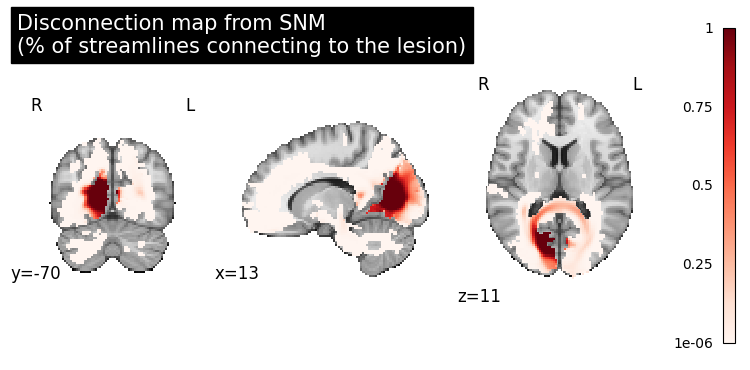

In [121]:
disconnection_path = '/tmp/outputs_snm/sub-01/ses-01/anat/sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-snm_disconnectionmap.nii.gz'
disconnection_img = nib.load(disconnection_path)

plotting.plot_stat_map(disconnection_img, 
                       radiological=True, 
                       title="Disconnection map from SNM \n(% of streamlines connecting to the lesion)", 
                       draw_cross=False, 
                       colorbar=True,
                       dim=-0.2,
                       cmap='Reds')

# Functional Lesion Network Mapping

Functional Lesion Network Mapping aims to map the functional brain circuitry connecting to the lesion. This is achieved by using a normative functional connectome - a collection of resting-state functional MRIs. Based on this connectome the average functional connectivity - i.e., the Pearson correlation of BOLD timeseries - between the lesion and every voxel in the connectome space is quantified.

As before we need to obtain a functional connectome. Lacuna facilitates to download the [GSP1000 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ILXIKS) which is openly available and the current field standard. Again, you have to get an access token. For this register on [Harvard Dataverse](https://dataverse.harvard.edu/), click on your username and then API Token.

Here, we will only fetch a test version of GSP1000 to keep the tutorial lightweight. The original dataset comprises ~200gb of data so you need space for that. However, the shown commands should work equally 

In [ ]:
!lacuna fetch gsp1000 \
    --output-dir /tmp/gsp1000_data \
    --api-key 2b07c7d0-c8b4-4d68-bf90-3d78f8763029 \
    --test-mode \
    --skip-checksum \
    --no-keep-original

In [124]:
!ls /tmp/gsp1000_data/

connectome_chunk_000.h5


In [126]:
!lacuna run fnm \
    /tmp/tutorial_data/ \
    /tmp/outputs_fnm/ \
    --connectome-path /tmp/gsp1000_data \
    --participant-label 01 \
    --mask-space MNI152NLin6Asym \
    --verbose

2026-01-20 15:44:59 - lacuna.cli.main - INFO - Lacuna CLI starting
2026-01-20 15:44:59 - lacuna.cli.main - INFO - Input: /tmp/tutorial_data
2026-01-20 15:44:59 - lacuna.cli.main - INFO - Output directory: /tmp/outputs_fnm
2026-01-20 15:44:59 - lacuna.cli.main - INFO - Analysis: fnm
2026-01-20 15:44:59 - lacuna.cli.main - INFO - Registering functional connectome: gsp1000_data
2026-01-20 15:44:59 - lacuna.cli.main - INFO - Running analysis: FunctionalNetworkMapping
2026-01-20 15:44:59 - lacuna.cli.main - INFO - 
2026-01-20 15:44:59 - lacuna.cli.main - INFO - ============================================================
2026-01-20 15:44:59 - lacuna.cli.main - INFO - DISCOVERY SUMMARY
2026-01-20 15:44:59 - lacuna.cli.main - INFO - ============================================================
2026-01-20 15:44:59 - lacuna.cli.main - INFO -   Total mask images: 1
2026-01-20 15:44:59 - lacuna.cli.main - INFO -   Unique subjects:   1
2026-01-20 15:44:59 - lacuna.cli.main - INFO -   Unique session

In [128]:
!ls /tmp/outputs_fnm/sub-01/ses-01/anat

sub-01_ses-01_desc-provenance.json
sub-01_ses-01_label-acuteinfarct_summarystatistics_stats.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_pfdrmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_pfdrmap.nii.gz
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_pfdrthresholdmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_pfdrthresholdmap.nii.gz
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_pmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_pmap.nii.gz
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_rmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_rmap.nii.gz
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_tmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_tmap.nii.gz
sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_zmap.json
sub-01_ses-01_space-MNI152NLin6Asym_label-acutein

Let's visualize the output

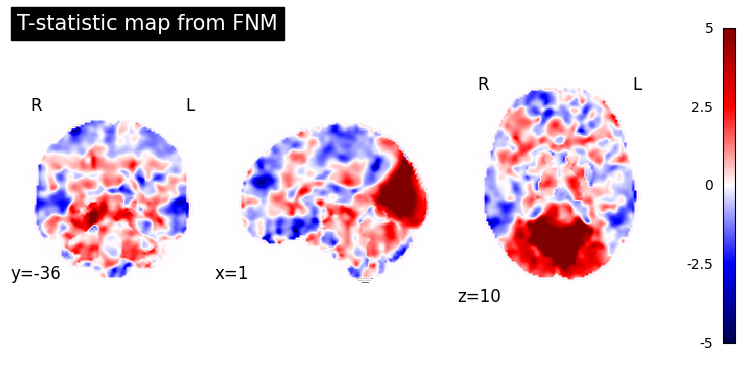

In [137]:
tmap_path = '/tmp/outputs_fnm/sub-01/ses-01/anat/sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_desc-fnm_tmap.nii.gz'
tmap_img = nib.load(tmap_path)

plotting.plot_stat_map(tmap_img, 
                       radiological=True, 
                       title="T-statistic map from FNМ", 
                       draw_cross=False, 
                       colorbar=True,
                       cmap='seismic',
                       vmin=-5,
                       vmax=5
                       )

The map looks a bit speckled but this is expected due to only a small fraction of connectome subjects being considered in this test run. Once the full connectome is used the map will be smoother.

This concludes the first analysis tutorial.